In [56]:
import pandas as pd
from IPython.display import display

pd.set_option('display.max_rows', 10)

'''
▓▓ - abilitie is used
▓░░░ - abilitie is used continuesly - channeled abities
CD - abilitie is on cooldown
. - abilitie is ready to be used

cooldown is measured in ticks
'''

# create table formating for each abilitie
icon_map = {}
for ab in ['Assault','Dismember','Slice','Slaughter','Sever']:
    ab_style = f'<div style="text-align:center">\n<img src="icons/{ab.lower()}.png" width="32"><br><span>{ab}</span></div>'
    icon_map.update({ab: ab_style})


abilitie_dmg = 1920
dmg_boosts = 18 # extra boost in %

# Define abilities with type 
#   dot is dmg over time --> bleed
#   dmg is in %, it will be multiplied with abilitie dmg later
abilities = {
    # basic
    'Sever': {'cd': 9,  'mechanic': 'instant', 'damage': 120, 'adrenaline': +8, 'type':'basic', 'hits':1},
    'Slice': {'cd': 5,  'mechanic': 'instant', 'damage': 105, 'adrenaline': +8, 'type':'basic', 'hits':1},
    'Dismember': {'cd': 25,  'mechanic': 'dot', 'damage': 115, 'adrenaline': +8, 'type':'basic', 'hits':5},
    
    # treshold
    'Assault': {'cd': 50, 'mechanic': 'channel', 'damage': 560, 'adrenaline': -15, 'type':'treshold', 'hits':4},    
    'Slaughter': {'cd': 50, 'mechanic': 'dot', 'damage': 175, 'adrenaline': -15, 'type':'treshold', 'hits':5},
    
     # ultimate
    'Overpower': {'cd': 50,  'mechanic': 'instant', 'damage': 600, 'adrenaline': -100, 'type':'ultimate', 'hits':1},
}

# Planned rotation
rotation = ['Assault','Slaughter','Dismember','Sever','Slice','Slice']
abilities = {k: v for k, v in abilities.items() if k in rotation} # filter out those that are not used so they dont show in result table

ticks = 25 # How long time period will be simulated
timeline = []
cooldowns = {a: 0 for a in abilities}
channels = {a: 0 for a in abilities}
adrenaline = 100 # starting adrenaline
adrenaline_upper_limit = 100
total_damage = 0
rot_index = 0

starting_adrenaline = adrenaline # for print statment at output
pending_bleed_dmg=[] # list to store all pending bleed for future ticks
channeled_statuss_visuals = ['▓░░░','▓▓░░','▓▓░░','▓▓▓░','▓▓▓░','▓▓▓▓','▓▓▓▓']
for t in range(ticks):
    row = {'Tick':t+1, 'Time(s)':round(t*0.6,1), 'Adrenaline':adrenaline, 'Damage':0, 'Total damage':0}
    
    # status marks
    for a in abilities:
        if channels[a] > 0:
            row[a] = channeled_statuss_visuals[-channels[a]] # abilitie is channeled on continue to work
        elif cooldowns[a] > 0:
            row[a] = 'CD' # cooldown
        else:
            row[a] = '.' # ready to use    
    
    # Use next ability from rotation if free
    if rot_index < len(rotation):
        abil = rotation[rot_index]
        # Can use if not channeling anything
        if all(v == 0 for v in channels.values()):
            if cooldowns[abil] == 0:
                data = abilities[abil]
                if data['mechanic'] == 'channel':
                    channels[abil] = data['hits'] * 2 # because 1 hit every 2 ticks (1.2s)
                    cooldowns[abil] = data['cd']
                    row[abil] = '▓░░░'
                    row['Damage'] += (data['damage'] / 100 * abilitie_dmg) * (1+dmg_boosts/100) / data['hits']
                    adrenaline += data['adrenaline']
                    adrenaline = adrenaline if adrenaline <= adrenaline_upper_limit else adrenaline_upper_limit
                    total_damage += row['Damage']
                    
                    new_stored_dmg=[]
                    for i in range(0, data['hits']-1):
                        new_stored_dmg.append(0)
                        new_stored_dmg.append(row['Damage'])
                    new_stored_dmg[0] = 0
                    new_stored_dmg.insert(0,0)
                    
                    currenty_pending_bleed = pending_bleed_dmg
                    pending_bleed_dmg = []
                    length = max(len(new_stored_dmg), len(currenty_pending_bleed))
                    for i in range(length):
                        pending_bleed_dmg.append((currenty_pending_bleed[i] if i < len(currenty_pending_bleed) else 0) +
                                                 (new_stored_dmg[i] if i < len(new_stored_dmg) else 0))                    
                    rot_index += 1
                
                elif data['mechanic'] == 'instant':
                    cooldowns[abil] = data['cd']
                    row[abil] = '▓▓'
                    row['Damage'] += (data['damage'] / 100 * abilitie_dmg) * (1+dmg_boosts/100)
                    adrenaline += data['adrenaline']
                    adrenaline = adrenaline if adrenaline <= adrenaline_upper_limit else adrenaline_upper_limit
                    total_damage += row['Damage']
                    rot_index += 1
                
                elif data['mechanic'] == 'dot':
                    cooldowns[abil] = data['cd']
                    row[abil] = '▓▓'
                    row['Damage'] += (data['damage'] / 100 * abilitie_dmg) * (1+dmg_boosts/100) / data['hits']
                    adrenaline += data['adrenaline']
                    adrenaline = adrenaline if adrenaline <= adrenaline_upper_limit else adrenaline_upper_limit
                    total_damage += row['Damage']
                    new_bleed_dmg=[]
                    for i in range(0, data['hits']-1):
                        new_bleed_dmg.append(0)
                        new_bleed_dmg.append(row['Damage'])
                    new_bleed_dmg[0] = 0
                    new_bleed_dmg.insert(0,0)
                    
                    currenty_pending_bleed = pending_bleed_dmg
                    pending_bleed_dmg = []
                    length = max(len(new_bleed_dmg), len(currenty_pending_bleed))
                    for i in range(length):
                        pending_bleed_dmg.append((currenty_pending_bleed[i] if i < len(currenty_pending_bleed) else 0) +
                                                 (new_bleed_dmg[i] if i < len(new_bleed_dmg) else 0))                        
                    rot_index += 1
        
    if len(pending_bleed_dmg)>0: # use pending bleed dmg from previous attacks
        row['Damage'] += pending_bleed_dmg[0]
        total_damage += pending_bleed_dmg[0]
        pending_bleed_dmg.pop(0)
            
    # Decrement counters
    for a in abilities:
        if channels[a] > 0:
            channels[a] -= 1
        if cooldowns[a] > 0:
            cooldowns[a] -= 1
    
    row['Adrenaline'] = adrenaline
    row['Total damage'] = total_damage
    timeline.append(row)

df = pd.DataFrame(timeline)
df_renamed = df.rename(columns=icon_map)
result_table = (df_renamed.style.hide(axis="index")
                 .set_table_attributes('style="display:block; max-height:700px; overflow:auto;"')
                 .format(precision=1).set_table_styles([
                     {'selector': 'thead th',
                      'props': [('background-color', '#1F1F1F'), ('position', 'sticky'), ('top', '0'), ('z-index', '2')]}])
                 .set_properties(**{'text-align': 'center'}))

print(f'\nStarting adrenaline: {starting_adrenaline}% / Damage boosts: +{dmg_boosts}%')
print(f'''Current rotation --> {str(rotation).replace("'",'')[1:-1]}''')
print(f'Total time: {ticks} ticks / Total Damage: {int(total_damage)} / DPS: {round(total_damage/(ticks*0.6),1)} / DPM: {round(total_damage/(ticks*0.6),1)*60}')

# Allow HTML rendering
from IPython.display import display, HTML
display(HTML(result_table.to_html(escape=False)))


Starting adrenaline: 100% / Damage boosts: +18%
Current rotation --> Assault, Slaughter, Dismember, Sever, Slice, Slice
Total time: 25 ticks / Total Damage: 26734 / DPS: 1782.3 / DPM: 106938.0


Tick,Time(s),Adrenaline,Damage,Total damage,Sever,Slice,Dismember,Assault,Slaughter
1,0.0,85,3171.8,3171.8,.,.,.,▓░░░,.
2,0.6,85,0.0,3171.8,.,.,.,▓░░░,.
3,1.2,85,3171.8,6343.7,.,.,.,▓▓░░,.
4,1.8,85,0.0,6343.7,.,.,.,▓▓░░,.
5,2.4,85,3171.8,9515.5,.,.,.,▓▓▓░,.
6,3.0,85,0.0,9515.5,.,.,.,▓▓▓░,.
7,3.6,85,3171.8,12687.4,.,.,.,▓▓▓▓,.
8,4.2,85,0.0,12687.4,.,.,.,▓▓▓▓,.
9,4.8,70,793.0,13480.3,.,.,.,CD,▓▓
10,5.4,78,521.1,14001.4,.,.,▓▓,CD,CD


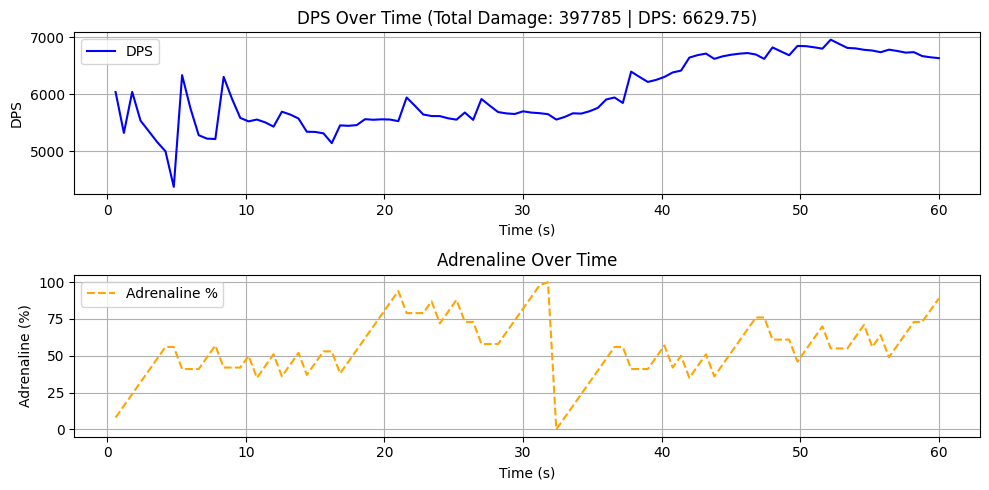

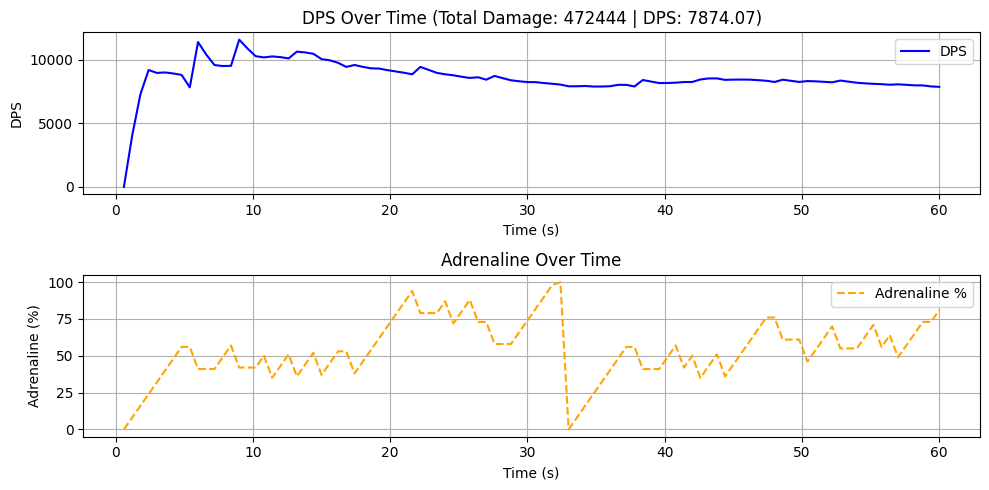

In [45]:
import tkinter as tk
from tkinter import scrolledtext, ttk, messagebox
from tkinter import ttk, messagebox
import random
import matplotlib.pyplot as plt

class Ability:
    def __init__(self, name, cooldown, adrenaline_cost, adrenaline_gain, damage_percent, is_threshold=False, is_ultimate=False, channeled_ticks=1, is_bleed=False, bleed_ticks=0):
        self.name = name
        self.cooldown = cooldown
        self.current_cooldown = 0
        self.adrenaline_cost = adrenaline_cost
        self.adrenaline_gain = adrenaline_gain
        self.damage_percent = damage_percent
        self.is_threshold = is_threshold
        self.is_ultimate = is_ultimate
        self.channeled_ticks = channeled_ticks
        self.is_bleed = is_bleed
        self.bleed_ticks = bleed_ticks

    def ready(self):
        return self.current_cooldown <= 0

    def use(self, base_damage, crit_chance, force_crit=False):
        self.current_cooldown = self.cooldown
        damage = self.damage_percent * base_damage // 100
        crit = False
    
        if self.is_bleed:
            return damage, False  # no crits on bleeds
    
        if force_crit or random.random() < crit_chance / 100:
            damage = int(damage * 1.5)
            crit = True
    
        return damage, crit

class RS3RotationSimulator:
    def __init__(self, master):
        self.master = master
        # master.title('RS3 Melee DPS Rotation Simulator')

        controls = tk.Frame(master)
        controls.pack(pady=5)

        tk.Label(controls, text='Duration (seconds):').grid(row=0, column=0, sticky='w')
        self.duration_entry = tk.Entry(controls)
        self.duration_entry.insert(0, '60')
        self.duration_entry.grid(row=0, column=1)

        tk.Label(controls, text='Start Adrenaline (%):').grid(row=1, column=0, sticky='w')
        self.adren_slider = tk.Scale(controls, from_=0, to=100, orient=tk.HORIZONTAL)
        self.adren_slider.set(0)
        self.adren_slider.grid(row=1, column=1)

        tk.Label(controls, text='Base Ability Damage:').grid(row=2, column=0, sticky='w')
        self.base_damage_entry = tk.Entry(controls)
        self.base_damage_entry.insert(0, '2300')
        self.base_damage_entry.grid(row=2, column=1)

        tk.Label(controls, text='Critical Chance (%):').grid(row=3, column=0, sticky='w')
        self.crit_entry = tk.Entry(controls)
        self.crit_entry.insert(0, '10')
        self.crit_entry.grid(row=3, column=1)

        self.abilities = {
            'Basic': [
                ('Slice', 3, 0, 8, 105),
                ('Sever', 3, 0, 8, 120),
                ('Punish', 3, 0, 8, 85),
                ('Fury', 10, 0, 8, 120, 1, False, 3),
                ('Greater Fury', 15, 0, 8, 130),
                ('Dismember', 15, 0, 8, 140, 1, False, 1, True, 10),
                ('Havoc', 10, 0, 8, 110),
                ('Kick', 15, 0, 8, 70),
                ('Chaos Roar', 60, 0, 8, 95),
                ('Greater Barge', 17, 0, 8, 85),
                ('Cleave', 12, 0, 8, 120),
                ('Decimate', 12, 0, 8, 120)
            ],
            'Threshold': [
                ('Assault', 30, 15, 0, 560, True, False, 3),
                ('Destroy', 20, 15, 0, 520, True, False, 3),
                ('Quake', 20, 15, 0, 145, True, False),
                ('Hurricane', 20, 15, 0, 285, True, False),
                ('Slaughter', 30, 15, 0, 175, True, False, 1, True, 10),
                ('Blood Tendrils', 45, 15, 0, 330, True, False)
            ],
            'Ultimate': [
                ('Berserk', 60, 100, 0, 0, False, True),
                ('Overpower', 30, 100, 0, 600, False, True),
                ('Meteor Strike', 60, 100, 0, 300, False, True)
            ]
        }

        self.ability_vars = {}
        row_offset = 4
        col = 0
        for section, abilities in self.abilities.items():
            tk.Label(controls, text=f'{section} Abilities:').grid(row=row_offset, column=col, sticky='w')
            row_offset += 1
            for name, *_ in abilities:
                var = tk.BooleanVar(value=True)
                cb = tk.Checkbutton(controls, text=name, variable=var)
                cb.grid(row=row_offset, column=col, sticky='w')
                self.ability_vars[name] = var
                row_offset += 1
            col += 1
            row_offset = 4

        self.button = tk.Button(master, text='Run Simulation', command=self.run_simulation)
        self.button.pack(pady=5)
        # self.close_button = tk.Button(master, text='Close', command=master.destroy)
        # self.close_button.pack(pady=5)
        
        self.text = scrolledtext.ScrolledText(master, width=70, height=25)
        self.text.pack()

    def run_simulation(self):
        self.text.delete(1.0, tk.END)

        tick_interval = 0.6
        seconds = self.duration_entry.get()
        total_ticks = int(int(seconds) / tick_interval)
        adrenaline = self.adren_slider.get()
        total_damage = 0
        active_berserk = 0
        chaos_roar_active = False
        greater_fury_crit = False
        endless_assault_ticks = 0
        meteor_strike_buff = 0
        ticks_since_last_attack = 100
        bleed_queue = []
        dps_log = []
        adren_log = []
        busy_ticks = 0

        try:
            base_damage = int(self.base_damage_entry.get())
            crit_chance = float(self.crit_entry.get())
            seconds = int(self.duration_entry.get())
        except ValueError:
            self.text.insert(tk.END, 'Invalid input. Please enter numeric values.\n')
            return

        abilities = []
        for section, group in self.abilities.items():
            for entry in group:
                name, cd, cost, gain, dmg, *flags = entry
                is_threshold = flags[0] if len(flags) > 0 else False
                is_ultimate = flags[1] if len(flags) > 1 else False
                channeled_ticks = flags[2] if len(flags) > 2 else 1
                is_bleed = flags[3] if len(flags) > 3 else False
                bleed_ticks = flags[4] if len(flags) > 4 else 0
                if self.ability_vars[name].get():
                    abilities.append(Ability(name, cd, cost, gain, dmg, is_threshold, is_ultimate, channeled_ticks, is_bleed, bleed_ticks))

        for tick in range(total_ticks):
            # Apply bleed damage
            for i in range(len(bleed_queue)-1, -1, -1):
                bleed = bleed_queue[i]
                bleed['remaining'] -= 1
                total_damage += bleed['damage']
                if bleed['remaining'] <= 0:
                    bleed_queue.pop(i)

            if busy_ticks > 0:
                busy_ticks -= 1
                dps_log.append(total_damage / ((tick + 1) * tick_interval))
                adren_log.append(adrenaline)
                ticks_since_last_attack += 1
                if meteor_strike_buff > 0:
                    meteor_strike_buff -= 1
                continue

            for ability in abilities:
                if ability.current_cooldown > 0:
                    ability.current_cooldown -= 1

            for ability in sorted(abilities, key=lambda a: (-a.is_ultimate, -a.is_threshold)):
                if ability.ready():
                    force_crit = False
                    apply_dot = False

                    if ability.name == 'Greater Barge':
                        ability.damage_percent = 85 + min(ticks_since_last_attack, 10) * 5
                        if ticks_since_last_attack >= 8:
                            endless_assault_ticks = 10
                        ticks_since_last_attack = 0

                    if ability.name == 'Chaos Roar':
                        chaos_roar_active = True

                    if ability.name == 'Greater Fury':
                        greater_fury_crit = True

                    if ability.name == 'Meteor Strike' and adrenaline >= 100:
                        meteor_strike_buff = 50  # 30s = 50 ticks

                    if ability.is_ultimate and adrenaline >= 100:
                        active_berserk = 20
                        adrenaline -= 100
                        damage, crit = ability.use(base_damage, crit_chance)
                        damage = 0  # ensures 'damage' is defined
                        buffs = []
                        if active_berserk > 0:
                            buffs.append('Berserk')
                        if endless_assault_ticks > 0:
                            buffs.append('Endless Assault')
                        if chaos_roar_active:
                            buffs.append('Chaos Roar')
                        if greater_fury_crit:
                            buffs.append('Greater Fury')
                        if meteor_strike_buff > 0:
                            buffs.append('Meteor Boost')
                        buff_string = f' [{', '.join(buffs)}]' if buffs else ''
                        
                        self.text.insert(tk.END, f'[{tick}] Used {ability.name} (Berserk ON), Adrenaline: {adrenaline}%{buff_string}\n')
                        break

                    elif ability.is_threshold and adrenaline >= 50:
                        if endless_assault_ticks > 0 and ability.channeled_ticks > 1:
                            apply_dot = True
                            endless_assault_ticks = 0

                        damage, crit = ability.use(base_damage, crit_chance, force_crit=greater_fury_crit and not ability.is_bleed)
                        if meteor_strike_buff > 0 and crit:
                            adrenaline = min(100, adrenaline + 8)
                        if chaos_roar_active:
                            damage *= 2
                            chaos_roar_active = False
                        if greater_fury_crit and not ability.is_bleed:
                            force_crit = True
                            greater_fury_crit = False

                        adrenaline -= ability.adrenaline_cost
                        if ability.is_bleed:
                            ticks_to_apply = min(ability.bleed_ticks, total_ticks - tick)
                            per_tick = damage // ability.bleed_ticks
                            bleed_queue.append({'damage': per_tick, 'remaining': ticks_to_apply})
                        else:
                            total_damage += damage * (2 if active_berserk > 0 else 1)
                        
                        buffs = []
                        if active_berserk > 0:
                            buffs.append('Berserk')
                        if endless_assault_ticks > 0:
                            buffs.append('Endless Assault')
                        if chaos_roar_active:
                            buffs.append('Chaos Roar')
                        if greater_fury_crit:
                            buffs.append('Greater Fury')
                        if meteor_strike_buff > 0:
                            buffs.append('Meteor Boost')
                        buff_string = f' [{', '.join(buffs)}]' if buffs else ''

                        self.text.insert(tk.END, f'[{tick}] Used {ability.name}, Damage: {damage}{' (CRIT!)' if crit else ''}, Adrenaline: {adrenaline}%{buff_string}\n')
                        busy_ticks = 0 if apply_dot else ability.channeled_ticks - 1
                        ticks_since_last_attack = 0
                        break

                    elif not ability.is_threshold and not ability.is_ultimate:
                        damage, crit = ability.use(base_damage, crit_chance, force_crit=greater_fury_crit and not ability.is_bleed)
                        if meteor_strike_buff > 0 and crit:
                            adrenaline = min(100, adrenaline + 8)
                        if chaos_roar_active:
                            damage *= 2
                            chaos_roar_active = False
                        if greater_fury_crit and not ability.is_bleed:
                            force_crit = True
                            greater_fury_crit = False

                        adrenaline = min(100, adrenaline + ability.adrenaline_gain)
                        if ability.is_bleed:
                            ticks_to_apply = min(ability.bleed_ticks, total_ticks - tick)
                            per_tick = damage // ability.bleed_ticks
                            bleed_queue.append({'damage': per_tick, 'remaining': ticks_to_apply})
                        else:
                            total_damage += damage * (2 if active_berserk > 0 else 1)
                            
                        buffs = []
                        if active_berserk > 0:
                            buffs.append('Berserk')
                        if endless_assault_ticks > 0:
                            buffs.append('Endless Assault')
                        if chaos_roar_active:
                            buffs.append('Chaos Roar')
                        if greater_fury_crit:
                            buffs.append('Greater Fury')
                        if meteor_strike_buff > 0:
                            buffs.append('Meteor Boost')
                        buff_string = f' [{', '.join(buffs)}]' if buffs else ''

                        self.text.insert(tk.END, f'[{tick}] Used {ability.name}, Damage: {damage}{' (CRIT!)' if crit else ''}, Adrenaline: {adrenaline}%{buff_string}\n')
                        busy_ticks = ability.channeled_ticks - 1
                        ticks_since_last_attack = 0
                        break

            if active_berserk > 0:
                active_berserk -= 1
            if endless_assault_ticks > 0:
                endless_assault_ticks -= 1
            if meteor_strike_buff > 0:
                meteor_strike_buff -= 1

            dps_log.append(total_damage / ((tick + 1) * tick_interval))
            adren_log.append(adrenaline)
            ticks_since_last_attack += 1

        self.text.insert(tk.END, f'\n--- Simulation Complete ---\n')
        self.text.insert(tk.END, f'Total Damage: {total_damage}\n')
        self.text.insert(tk.END, f'Duration: {seconds}s | DPS: {total_damage / seconds:.2f}\n')

        times = [tick_interval * (i + 1) for i in range(len(dps_log))]
        
        plt.figure(figsize=(10, 5))
        
        # Subplot 1: DPS over time
        plt.subplot(2, 1, 1)
        plt.plot(times, dps_log, label='DPS', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('DPS')
        plt.title(f'DPS Over Time (Total Damage: {total_damage} | DPS: {total_damage / seconds:.2f})')
        plt.grid(True)
        plt.legend()
        
        # Subplot 2: Adrenaline over time
        plt.subplot(2, 1, 2)
        plt.plot(times, adren_log, label='Adrenaline %', color='orange', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Adrenaline (%)')
        plt.title('Adrenaline Over Time')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        
#------------------------------------------------------------------------------------------------------


# Simulated ability data for testing
ABILITY_DATA = {
    'Slice': {'mechanic': 'Basic', 'damage': 105, 'cooldown': 3, 'adren_cost': 0, 'adren_gain': 8, 'channeled': 1, 'is_bleed': False},
    'Sever': {'mechanic': 'Basic', 'damage': 120, 'cooldown': 3, 'adren_cost': 0, 'adren_gain': 8, 'channeled': 1, 'is_bleed': False},
    'Assault': {'mechanic': 'Threshold', 'damage': 560, 'cooldown': 30, 'adren_cost': 15, 'adren_gain': 0, 'channeled': 3, 'is_bleed': False},
    'Dismember': {'mechanic': 'Basic', 'damage': 140, 'cooldown': 15, 'adren_cost': 0, 'adren_gain': 8, 'channeled': 1, 'is_bleed': True, 'bleed_ticks': 10},
    'Greater Fury': {'mechanic': 'Basic', 'damage': 130, 'cooldown': 15, 'adren_cost': 0, 'adren_gain': 8, 'channeled': 1, 'is_bleed': False},
    'Overpower': {'mechanic': 'Ultimate', 'damage': 600, 'cooldown': 30, 'adren_cost': 100, 'adren_gain': 0, 'channeled': 1, 'is_bleed': False},
}

class ManualRotationBuilder:
    def __init__(self, master):
        self.master = master

        # Top config frame
        top_config_frame = tk.Frame(master)
        top_config_frame.pack(side=tk.TOP, anchor='n', pady=5)

        tk.Label(top_config_frame, text='--- Simulation Config ---').grid(row=0, column=0, columnspan=2)

        tk.Label(top_config_frame, text='Duration (s):').grid(row=1, column=0, sticky='e')
        self.duration_entry = tk.Entry(top_config_frame)
        self.duration_entry.insert(0, '60')
        self.duration_entry.grid(row=1, column=1)

        tk.Label(top_config_frame, text='Start Adrenaline (%):').grid(row=2, column=0, sticky='e')
        self.adren_slider = tk.Scale(top_config_frame, from_=0, to=100, orient=tk.HORIZONTAL)
        self.adren_slider.set(0)
        self.adren_slider.grid(row=2, column=1)

        tk.Label(top_config_frame, text='Base Ability Damage:').grid(row=3, column=0, sticky='e')
        self.base_damage_entry = tk.Entry(top_config_frame)
        self.base_damage_entry.insert(0, '2300')
        self.base_damage_entry.grid(row=3, column=1)

        tk.Label(top_config_frame, text='Critical Chance (%):').grid(row=4, column=0, sticky='e')
        self.crit_entry = tk.Entry(top_config_frame)
        self.crit_entry.insert(0, '10')
        self.crit_entry.grid(row=4, column=1)

        # Wrap picker, timeline, controls into one row
        middle_frame = tk.Frame(master)
        middle_frame.pack(side=tk.TOP, pady=10)
        
        picker_frame = tk.Frame(middle_frame)
        picker_frame.pack(side=tk.LEFT, padx=10, anchor='n')
        
        timeline_frame = tk.Frame(middle_frame)
        timeline_frame.pack(side=tk.LEFT, padx=10, anchor='n')
        
        controls_frame = tk.Frame(middle_frame)
        controls_frame.pack(side=tk.LEFT, padx=10, anchor='n')
        
        output_frame = tk.Frame(master)
        output_frame.pack(side=tk.TOP, fill=tk.BOTH, padx=20, pady=5)
        
        self.output_text = scrolledtext.ScrolledText(output_frame, width=120, height=12, state=tk.DISABLED)
        self.output_text.pack(fill=tk.BOTH, expand=True)

        # Picker UI
        tk.Label(picker_frame, text='Available Abilities').pack()
        self.ability_var = tk.StringVar()
        self.ability_menu = ttk.Combobox(picker_frame, textvariable=self.ability_var, width=25)
        self.ability_menu['values'] = list(ABILITY_DATA.keys())
        self.ability_menu.pack(pady=5)
        tk.Button(picker_frame, text='Add to Rotation', command=self.add_to_rotation).pack()

        # Timeline UI
        tk.Label(timeline_frame, text='Manual Rotation Order').pack()
        self.rotation_listbox = tk.Listbox(timeline_frame, width=35, height=20)
        self.rotation_listbox.pack()

        # Controls
        tk.Button(controls_frame, text='↑ Move Up', command=self.move_up).pack(pady=2)
        tk.Button(controls_frame, text='↓ Move Down', command=self.move_down).pack(pady=2)
        tk.Button(controls_frame, text='Remove Selected', command=self.remove_selected).pack(pady=2)
        tk.Button(controls_frame, text='Clear All', command=self.clear_all).pack(pady=2)
        tk.Button(controls_frame, text='Simulate', command=self.simulate_rotation).pack(pady=10)

    def add_to_rotation(self):
        selection = self.ability_var.get()
        if selection:
            self.rotation_listbox.insert(tk.END, selection)

    def move_up(self):
        sel = self.rotation_listbox.curselection()
        if not sel or sel[0] == 0:
            return
        i = sel[0]
        text = self.rotation_listbox.get(i)
        self.rotation_listbox.delete(i)
        self.rotation_listbox.insert(i - 1, text)
        self.rotation_listbox.select_set(i - 1)

    def move_down(self):
        sel = self.rotation_listbox.curselection()
        if not sel or sel[0] == self.rotation_listbox.size() - 1:
            return
        i = sel[0]
        text = self.rotation_listbox.get(i)
        self.rotation_listbox.delete(i)
        self.rotation_listbox.insert(i + 1, text)
        self.rotation_listbox.select_set(i + 1)

    def remove_selected(self):
        sel = self.rotation_listbox.curselection()
        if sel:
            self.rotation_listbox.delete(sel[0])

    def clear_all(self):
        self.rotation_listbox.delete(0, tk.END)

    def simulate_rotation(self):
        try:
            duration = int(self.duration_entry.get())
            base_damage = int(self.base_damage_entry.get())
            crit_chance = float(self.crit_entry.get())
        except ValueError:
            messagebox.showerror('Error', 'Invalid config input.')
            return

        rotation = self.rotation_listbox.get(0, tk.END)
        if not rotation:
            messagebox.showinfo('Info', 'Rotation is empty.')
            return

        total_damage, dps_log, adren_log, log_lines = self.run_manual_simulation(
            list(rotation), duration, base_damage, self.adren_slider.get(), crit_chance
        )

        # Show log in scrollable popup
        log_window = tk.Toplevel(self.master)
        log_window.title('Simulation Log')
        txt = scrolledtext.ScrolledText(log_window, width=80, height=25)
        txt.pack()
        txt.insert(tk.END, '\n'.join(log_lines))
        txt.insert(tk.END, f'\n\nTotal Damage: {total_damage}')
        txt.insert(tk.END, f'\nDPS: {total_damage / duration:.2f}')

        # Plot DPS and Adrenaline
        times = [0.6 * (i + 1) for i in range(len(dps_log))]
        plt.figure(figsize=(10, 8))

        plt.subplot(2, 1, 1)
        plt.plot(times, dps_log, label='DPS', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('DPS')
        plt.title('DPS Over Time')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(times, adren_log, label='Adrenaline', linestyle='--', color='orange')
        plt.xlabel('Time (s)')
        plt.ylabel('Adrenaline (%)')
        plt.title('Adrenaline Over Time')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def run_manual_simulation(self, rotation, duration, base_damage, start_adren, crit_chance):
        tick_interval = 0.6
        total_ticks = int(duration / tick_interval)
        adrenaline = start_adren
        total_damage = 0
        dps_log = []
        adren_log = []
        bleed_queue = []
        busy_ticks = 0
        log_lines = []
        ability_cooldowns = {name: 0 for name in set(rotation)}
        ability_index = 0

        for tick in range(total_ticks):
            # Apply bleed
            for i in range(len(bleed_queue)-1, -1, -1):
                bleed = bleed_queue[i]
                bleed['remaining'] -= 1
                total_damage += bleed['damage']
                if bleed['remaining'] <= 0:
                    bleed_queue.pop(i)

            if busy_ticks > 0:
                busy_ticks -= 1
                dps_log.append(total_damage / ((tick + 1) * tick_interval))
                adren_log.append(adrenaline)
                continue

            for ab_name in ability_cooldowns:
                if ability_cooldowns[ab_name] > 0:
                    ability_cooldowns[ab_name] -= 1

            if ability_index < len(rotation):
                name = rotation[ability_index]
                ab = ABILITY_DATA.get(name)
                ability_index += 1
                if ab is None or ability_cooldowns[name] > 0:
                    continue

                if ab['mechanic'] == 'Ultimate' and adrenaline < ab['adren_cost']:
                    continue
                elif ab['mechanic'] == 'Threshold' and adrenaline < 50:
                    continue

                ability_cooldowns[name] = ab['cooldown']
                adrenaline = max(0, adrenaline - ab['adren_cost'])
                adrenaline = min(100, adrenaline + ab['adren_gain'])
                is_crit = False
                damage = ab['damage'] * base_damage // 100

                if not ab.get('is_bleed', False) and random.random() < crit_chance / 100:
                    damage = int(damage * 1.5)
                    is_crit = True

                if ab.get('is_bleed', False):
                    ticks = min(ab.get('bleed_ticks', 10), total_ticks - tick)
                    per_tick = damage // ticks
                    bleed_queue.append({'damage': per_tick, 'remaining': ticks})
                else:
                    total_damage += damage

                log_lines.append(f'[{tick}] Used {name}, Damage: {damage}{' (CRIT!)' if is_crit else ''}, Adrenaline: {adrenaline}%')
                busy_ticks = ab['channeled'] - 1

            dps_log.append(total_damage / ((tick + 1) * tick_interval))
            adren_log.append(adrenaline)

        return total_damage, dps_log, adren_log, log_lines
            
        self.output_text.config(state=tk.NORMAL)
        self.output_text.delete(1.0, tk.END)
        self.output_text.insert(tk.END, '\n'.join(log_lines))
        self.output_text.insert(tk.END, f'\n\n--- Summary ---\n')
        self.output_text.insert(tk.END, f'Total Damage: {total_damage}\n')
        self.output_text.insert(tk.END, f'DPS: {total_damage / duration:.2f}\n')
        self.output_text.config(state=tk.DISABLED)



# Run GUI
if __name__ == '__main__':
    root = tk.Tk()
    root.title('RS3 Melee DPS Simulator')
    root.geometry('600x800')  # Adjust size if needed

    # Create notebook (tab controller)
    notebook = ttk.Notebook(root)
    notebook.pack(fill='both', expand=True)

    # Create tabs
    simulator_tab = tk.Frame(notebook)
    rotation_tab = tk.Frame(notebook)

    notebook.add(simulator_tab, text='Auto Simulator')
    notebook.add(rotation_tab, text='Manual Rotation Builder')

    # Init simulator UI in first tab
    app = RS3RotationSimulator(simulator_tab)

    # Init manual rotation builder in second tab
    manual = ManualRotationBuilder(rotation_tab)

    root.mainloop()
